In [94]:
import lnetreduce

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import io

def convert_image(im):
    b = BytesIO()
    b.write(im.data)
    data = b.getvalue()
    im_conv = Image.open(io.BytesIO(data))
    return im_conv

We load the file containing the model from https://link.springer.com/chapter/10.1007/978-3-030-60327-4_3#Fig2
![](https://media.springernature.com/original/springer-static/image/chp%3A10.1007%2F978-3-030-60327-4_3/MediaObjects/496159_1_En_3_Fig2_HTML.png)

With the $\epsilon$ orders provided in the paper, the reduction algorithm ends up with a cycle containing two kinetic rates of the same order 0, which formally leads to error message. To avoid this, we modify the reaction rate S2->S1 to the order -3. This won't change the conclusion about emergence of slow time scales not initially present in the initial reaction rates

<class 'networkx.classes.digraph.DiGraph'>


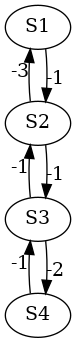

In [95]:
# load the model
filename = 'models/petrov1.csv'
timescale = 1
G = lnetreduce.load_graph(filename)
print(type(G))
lnetreduce.plot_graph(G)

Now we reduce the model and show the resulting orders of kinetic rates.

One can notice that there is a reaction S4->S2 of order 0, slower than any initial reaction rate

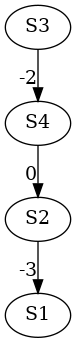

In [96]:
uG = lnetreduce.reduce_graph(G)
lnetreduce.plot_graph(uG)

### Now let us investigate many different distribution of kinetic orders in this example
### We will test $N=3^6=729$ possible combinations of kinetic orders $-1,-2,-3$ on each reaction

In [97]:
from itertools import product

edge_labels = nx.get_edge_attributes(G, 'weight')
orders = list(product([-1,-2,-3], repeat = len(edge_labels)))
graphs = []
for p in orders:
    for i,e in enumerate(edge_labels):
        edge_labels[e] = p[i]
    G1 = G.copy()
    nx.set_edge_attributes(G1, edge_labels, 'weight')
    graphs.append(G1)
print(len(graphs),' graphs generated.')

729  graphs generated.


Here we reduce all the graphs and find that in 80% of cases we can not apply the complete reduction algorithm, that there are 3 graphs with slow transients, and there are 9 unique up to isomorphism reduced graphs

In [98]:
# generate a list of unique up to isomorphism reduced graphs
# we also seek for the appearance of super-slow timescales, not initially present in the system

def nm(n1,n2):
    return n1['id'] == n2['id']
    
def get_max_timescale(G):
    return max( [ w for src,tgt,w in G.edges(data='weight') ] )

max_timescale = get_max_timescale(G)
print('Maximum timescale =', max_timescale)

slow_graphs = []
slow_timescales = []
unique_reduced = []
counts = []
count_errors = 0
for gr in graphs:
    try:
        ugr = lnetreduce.reduce_graph(gr)
    except:
        count_errors += 1
        continue
    
    mx_ts = get_max_timescale(ugr)
    if mx_ts > max_timescale:
        slow_graphs.append(gr)
        slow_timescales.append(mx_ts)
    node_ids = {}
    for n in ugr.nodes:
        node_ids[n] = n
    nx.set_node_attributes(ugr,node_ids,'id')    
    found = False
    for i,red_gr in enumerate(unique_reduced):
        node_ids = {}
        for n in red_gr.nodes:
            node_ids[n] = n
        nx.set_node_attributes(red_gr,node_ids,'id')
        if nx.is_isomorphic(ugr,red_gr,node_match=nm):
        #if nx.is_isomorphic(ugr,red_gr):
            found = True
            counts[i] = counts[i]+1
    if not found:
        unique_reduced.append(ugr)
        counts.append(1)
print('Fraction of reduction errors=',count_errors/len(graphs))
print('Unique graphs=',len(unique_reduced))
print('Distribution of unique graphs freqs=',counts)
total_counts = 0
for c in counts:
    total_counts+=c
print('Slow graphs=',len(slow_graphs))
print('Slow timescales=',slow_timescales)

Maximum timescale = -1
Fraction of reduction errors= 0.8052126200274349
Unique graphs= 6
Distribution of unique graphs freqs= [49, 15, 49, 7, 7, 15]
Slow graphs= 3
Slow timescales= [0, 0, 0]


Number of slow graphs =  3


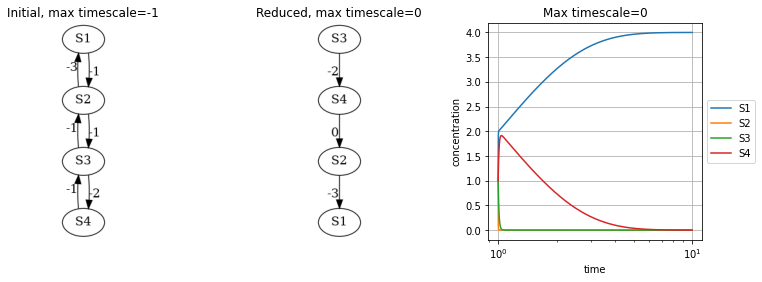

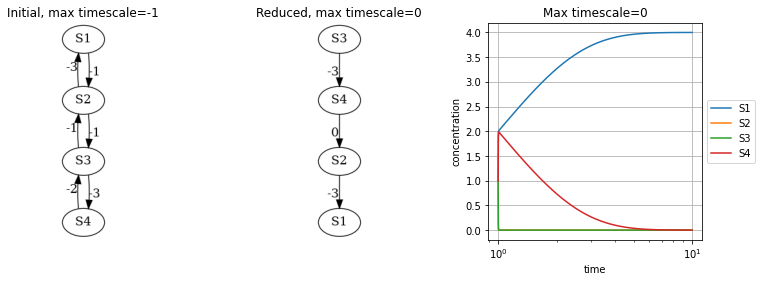

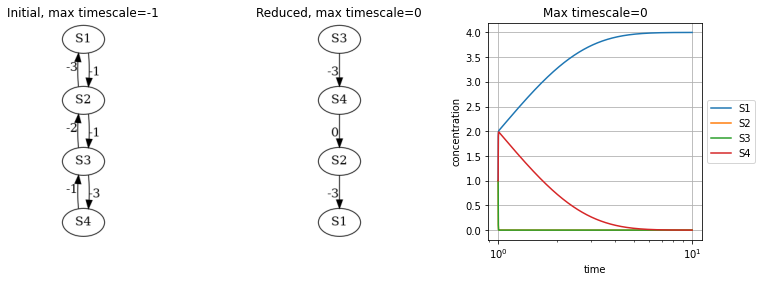

In [104]:
# draw slow graphs
print('Number of slow graphs = ',len(slow_graphs))

max_number_of_graphs = 5
most_slow = True
if most_slow:
    irx = np.argsort(-np.array(slow_timescales))
else:
    irx = np.argsort(np.array(slow_timescales))
    
for k,i in enumerate(irx):
    plt.figure(figsize=(13.0,4.0))
    plt.subplot(1,3,1)
    ugr = slow_graphs[i]
    plt.imshow(convert_image(lnetreduce.plot_graph(ugr)))
    plt.axis('off')
    plt.title('Initial, max timescale='+str(get_max_timescale(ugr)))

    plt.subplot(1,3,2)
    ugr = lnetreduce.reduce_graph(ugr)
    plt.imshow(convert_image(lnetreduce.plot_graph(ugr)))
    plt.axis('off')
    plt.title('Reduced, max timescale='+str(slow_timescales[i]))

    plt.subplot(1,3,3)
    lnetreduce.simulate_and_plot(ugr, timescale, title='Max timescale='+str(slow_timescales[i]), method='odeint')
    plt.show()
    
    if k > max_number_of_graphs: break

Number of unique graphs =  6


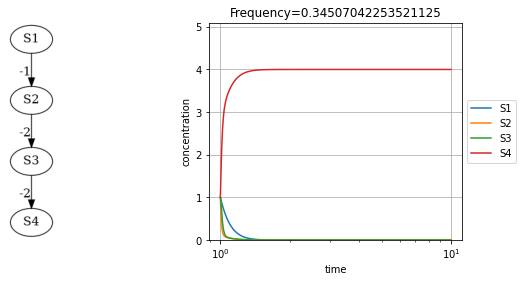

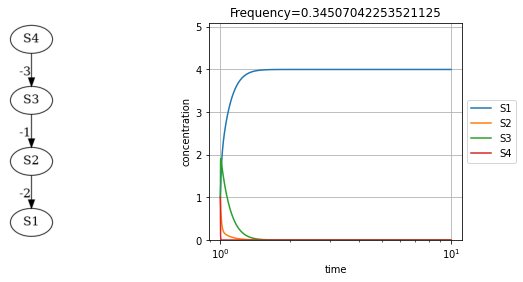

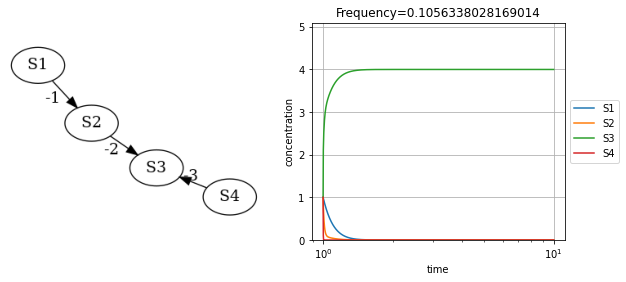

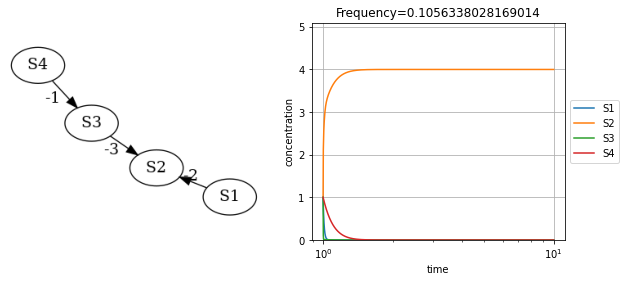

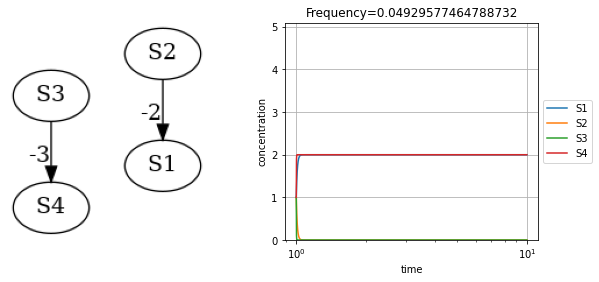

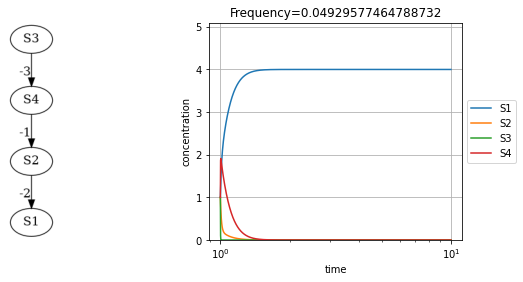

In [108]:
# draw unique graphs
print('Number of unique graphs = ',len(unique_reduced))


max_number_of_graphs = 20
most_frequent = True
if most_frequent:
    irx = np.argsort(-np.array(counts))
else:
    irx = np.argsort(np.array(counts))
    
for k,i in enumerate(irx):
    ugr = unique_reduced[i]
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(convert_image(lnetreduce.plot_graph(ugr)))
    plt.axis('off')
    plt.subplot(1,2,2)
    lnetreduce.simulate_and_plot(ugr, timescale, title='Frequency='+str(counts[i]/total_counts), method='odeint')
    plt.ylim([0,5.1])
    plt.show()

    if k > max_number_of_graphs: break